### Advanced techniques for solving the TSP

In this tutorial, we will solve the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) using different modeling techniques.

<i>Note that this is just an academic exercise done for demonstration purposes, with no intention to propose or claim new solution methods for solving the TSP. Moreover, we refer to the state-of-the-art solver for the TSP and other related problems [Concorde TSP solver](https://www.math.uwaterloo.ca/tsp/concorde.html).</i>

In [77]:
# first we install the requirements
%pip install pyscipopt networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


##### First (incomplete) formulation


Let's start with the standard formulation, where $x_{ij} \in \{0,1\}, \forall i,j \in \mathcal{N}$ represents if the tour uses the edge $(i,j)$ (i.e. if we go from city $i$ to $j$) in the final solution. An optimal tour can be found by solving:
$$
\min \sum_{i,j \in \mathcal{N}} c_{ij} x_{ij}
$$

subject to:

* We have to enter and leave every city, and source node cannot be the same as the destination node: 
$$
\sum_{j \in \mathcal{N}} x_{ij} = 1, \quad \forall i \in \mathcal{N} \\
\sum_{j \in \mathcal{N}} x_{ji} = 1, \quad \forall i \in \mathcal{N} \\
x_{ii} = 0, \quad \forall i \in \mathcal{N}
$$

We overlook subtour elimination constraints for now.

In [78]:
import pyscipopt as scip
import numpy as np

'''Create random TSP problem data'''
n = 10
CITIES = range(n)  # set of cities: 0..n-1

np.random.seed(0)

X = 100 * np.random.rand(n)
Y = 100 * np.random.rand(n)

XY = (X, Y)

# Compute distance matrix
dist = np.ceil(np.sqrt ((X.reshape(n,1) - X.reshape(1,n))**2 +
                        (Y.reshape(n,1) - Y.reshape(1,n))**2))

# Create problem
model = scip.Model()

# Create variables as a square matrix of binary variables. Note
# the use of p.addVariables to ensure NumPy uses the Xpress operations for handling these vectors.
x = {}
for i in CITIES:
    for j in CITIES:
        x[i, j] = model.addVar(vtype="B", name="x_{i}_{j}", obj=dist[i][j])

# Degree constraints
for i in CITIES:
    model.addCons(scip.quicksum(x[i,j] for j in range(n)) == 1)
    model.addCons(scip.quicksum(x[j,i] for j in range(n)) == 1)
    model.addCons(x[i,i] == 0)

model.optimize()

presolving:
(round 1, fast)       10 del vars, 10 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 20 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
(round 2, exhaustive) 10 del vars, 10 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 20 upgd conss, 0 impls, 20 clqs
   (0.0s) probing: 51/90 (56.7%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.0s) symmetry computation finished: 1 generators found (max: 1500, log10 of symmetry group size: 0.3)
(round 3, exhaustive) 10 del vars, 10 del conss, 1 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 20 upgd conss, 0 impls, 20 clqs
presolving (4 rounds: 4 fast, 3 medium, 3 exhaustive):
 10 deleted vars, 10 deleted constraints, 1 added constraints, 10 tightened boun

Now let's use matplotlib and networkx to visualize the solution for the Xpress interface and check if there are any subtours:

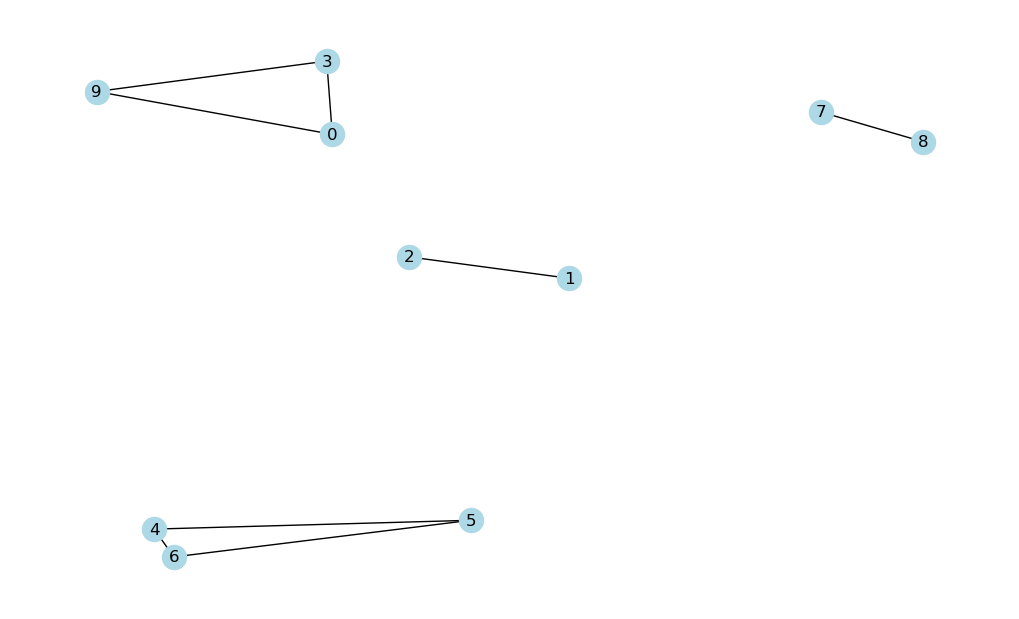

In [79]:
# Visualize solution using networkx and matplotlib
import networkx as nx 
import matplotlib.pyplot as plt
import itertools

def plot_sol(model):

    # collect the edges: if the value of x[i,j] is 1, then the edge (i,j) is in the solution
    edges = []
    for (i,j) in itertools.permutations(CITIES, 2):
        if model.getVal(x[i,j]) > 0.5: # variable is binary so > 0.5 --> is 1
            edges.append( (i,j) )

    # create dictionary with coordinates for each node to plot the graph 
    xy = {}
    for i in range(n):
        xy[i] = (X[i], Y[i])

    # make figure look nicer
    plt.figure(figsize=(10,6), dpi=100)

    # create empty graph
    optgraph = nx.Graph()

    # add edges
    optgraph.add_edges_from(edges)

    # draw the nodes, with labels in the position xy (see when we read the instance)
    nx.draw(optgraph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

    # show drawing
    plt.show()

# Plot solution

plot_sol(model)

As you can see, the solution contains subtours, and therefore it is not a valid solution for the problem yet. We need to add subtour elimination constraints, that is, prevent each and every possible subtour from occurring.

**EXERCISE 3.1**: Add the following subtour elimination constraints to the problem, solve it and plot the solution:

$$
\sum_{i,j \in S} x_{ij} \leq |S| - 1 \quad \forall S \subsetneq N,\ |S| \geq 2
$$

_Hint: Use [itertools.combinations](https://docs.python.org/3/library/itertools.html#itertools.combinations) to return all possible combinations (subtours) for each possible subtour length (number of cities)._

presolving:
(round 1, fast)       10 del vars, 10 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 65 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
(round 2, exhaustive) 10 del vars, 10 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 1032 upgd conss, 0 impls, 65 clqs
   (0.1s) probing: 51/90 (56.7%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.1s) probing aborted: 50/50 successive totally useless probings
   (0.1s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.1s) symmetry computation finished: 1 generators found (max: 1500, log10 of symmetry group size: 0.3)
(round 3, exhaustive) 11 del vars, 10 del conss, 1 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 1032 upgd conss, 0 impls, 64 clqs
(round 4, fast)       11 del vars, 11 del conss, 1 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 1032 upgd conss, 0 impls, 6

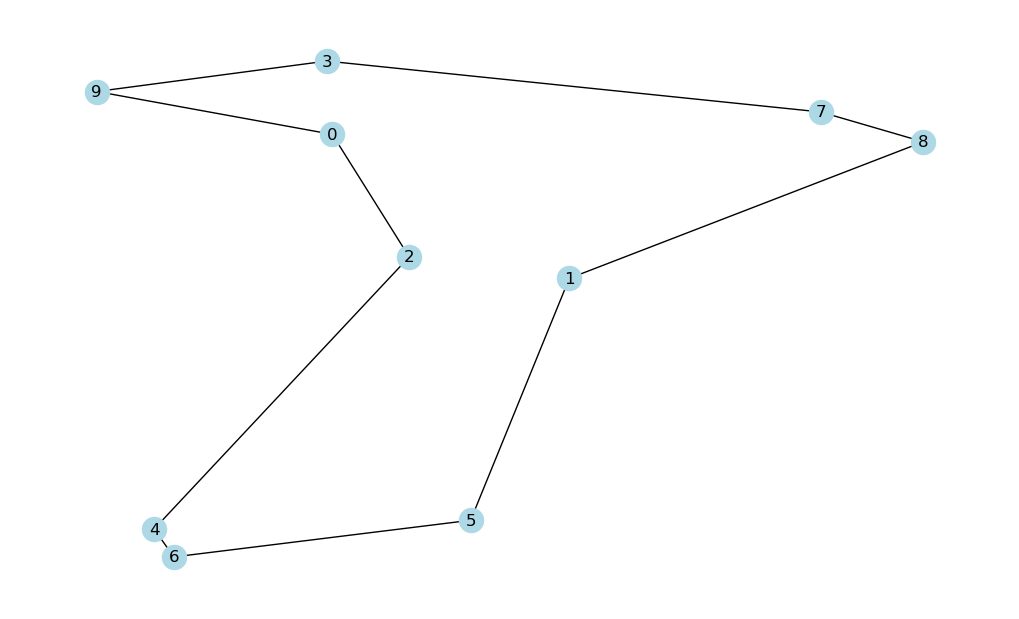

In [80]:
# PySCIPOpt Interface (solution)
from pyscipopt import Model, quicksum
import itertools

# Create model
model = Model("TSP")

# Create variables
x = {}
for i in CITIES:
    for j in CITIES:
        x[i,j] = model.addVar(vtype="B", name=f"x_{i}_{j}")

# Add constraints
# Each city must be visited exactly once (in-degree)
for i in CITIES:
    model.addCons(quicksum(x[j,i] for j in CITIES) == 1)

# Must leave each city exactly once (out-degree)
for i in CITIES:
    model.addCons(quicksum(x[i,j] for j in CITIES) == 1)

# No self-loops
for i in CITIES:
    model.addCons(x[i,i] == 0)

# Add subtour elimination constraints
for L in range(2, len(CITIES)):
    for subset in itertools.combinations(CITIES, L):
        model.addCons(quicksum(x[i,j] for i in subset for j in subset) <= len(subset) - 1)

# Set objective
model.setObjective(quicksum(dist[i][j] * x[i,j] for i in CITIES for j in CITIES), "minimize")

# Solve the problem
model.optimize()

# Define plot_sol function for PySCIPOpt
def plot_sol(model):
    # collect the edges: if the value of x[i,j] is 1, then the edge (i,j) is in the solution
    edges = []
    for (i,j) in itertools.permutations(CITIES, 2):
        if model.getVal(x[i,j]) > 0.5:  # variable is binary so > 0.5 --> is 1
            edges.append((i,j))

    # create dictionary with coordinates for each node to plot the graph 
    xy = {}
    for i in range(n):
        xy[i] = (X[i], Y[i])

    # make figure look nicer
    plt.figure(figsize=(10,6), dpi=100)

    # create empty graph
    optgraph = nx.Graph()

    # add edges
    optgraph.add_edges_from(edges)

    # draw the nodes, with labels in the position xy (see when we read the instance)
    nx.draw(optgraph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

    # show drawing
    plt.show()

# Plot solution
if model.getStatus() != "optimal":
    print("Solve status:", model.getStatus())
else:
    plot_sol(model)

PySCIPOpt is the Python interface for the SCIP Optimization Suite, which is one of the fastest non-commercial solvers for mixed integer programming (MIP) and mixed integer nonlinear programming (MINLP).

Make sure you have PySCIPOpt installed (`pip install pyscipopt`) before running this code.

The solution is now valid and complete, since an Hamiltonian tour (no subtours) has been formed. However, you could experience that the problem building and solving times are rather high for a TSP with only 17 cities.

This is due to the complete enumeration of all possible subtours, whose number grows exponentially with the instance size making the problem creation and solving times lengthy when problems become realistically large.

##### Formulation using the Miller, Tucker, Zemlin subtour elimination constraints

Now we will model the same problem but using the Miller, Tucker, Zemlin subtour elimination constraints, which requires a new set of continuous variables:

$t_i$ = step at which node $i$ is visited, $\forall i = {1,...,|\mathcal{N}|}$

which are used as auxiliary variables for the formulation of subtour elimination constraints. Although a new set of real variables of size $|\mathcal{N}|$ is introduced, we are able to prevent all subtours by introducing a set of constraints of size $(|\mathcal{N}|-1)^2$, considerably reducing the problem size and complexity when comparing with the previous formulation:

$$
\min \sum_{i,j \in \mathcal{N}} c_{ij} x_{ij}
$$

subject to:

* We have to enter and leave every city, and source node cannot be the destination node for any move: 
$$
\sum_{j \in \mathcal{N}} x_{ij} = 1, \quad \forall i \in \mathcal{N} \\
\sum_{j \in \mathcal{N}} x_{ji} = 1, \quad \forall i \in \mathcal{N} \\
x_{ii} = 0, \quad \forall i \in \mathcal{N}
$$
* Miller, Tucker, Zemlin subtour elimination constraints:
$$
t_j \geq t_i + 1 - (n-1)*(1 - x_{ij}), \forall i,j = {1,...,|\mathcal{N}|}
$$

with $n = |\mathcal{N}|$.

**EXERCISE 3.2**: Adjust the previous model to represent the Miller, Tucker, Zemlin formulation of the TSP

presolving:
(round 1, fast)       11 del vars, 19 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 20 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
(round 2, exhaustive) 11 del vars, 19 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 20 upgd conss, 0 impls, 20 clqs
   (0.0s) probing cycle finished: starting next cycle
   (0.0s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.0s) no symmetry present
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 11 deleted vars, 19 deleted constraints, 0 added constraints, 10 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 72 implications, 20 cliques
presolved problem has 99 variables (90 bin, 0 int, 0 impl, 9 cont) and 92 constraints
     20 constraints of type <setppc>
     72 constraints of type <linear>
transformed objective value is always integral (scale: 1)
Presolving Time:

0s|     1 |     0 |    65 |     - |  2108k |   0 |  99 |  99 | 107 |  15 |  6 |   6 |   0 | 2.068000e+02 | 3.940000e+02 |  90.52%| unknown
  0.0s|     1 |     0 |    81 |     - |  2145k |   0 |  99 |  99 | 110 |  18 |  7 |   6 |   0 | 2.425000e+02 | 3.940000e+02 |  62.47%| unknown
  0.0s|     1 |     0 |    85 |     - |  2235k |   0 |  99 |  99 | 112 |  20 |  8 |   6 |   0 | 2.595000e+02 | 3.940000e+02 |  51.83%| unknown
  0.0s|     1 |     0 |    88 |     - |  2246k |   0 |  99 |  99 | 114 |  22 | 10 |   6 |   0 | 2.595000e+02 | 3.940000e+02 |  51.83%| unknown
  0.0s|     1 |     0 |    94 |     - |  2292k |   0 |  99 |  99 | 116 |  24 | 11 |   6 |   0 | 2.595000e+02 | 3.940000e+02 |  51.83%| unknown
  0.0s|     1 |     0 |    96 |     - |  2376k |   0 |  99 |  99 | 117 |  25 | 12 |   6 |   0 | 2.595000e+02 | 3.940000e+02 |  51.83%| unknown
  0.0s|     1 |     0 |   105 |     - |  2389k |   0 |  99 |  99 | 121 |  29 | 13 |   6 |   0 | 2.630000e+02 | 3.940000e+02 |  49.81%| unknown
  0

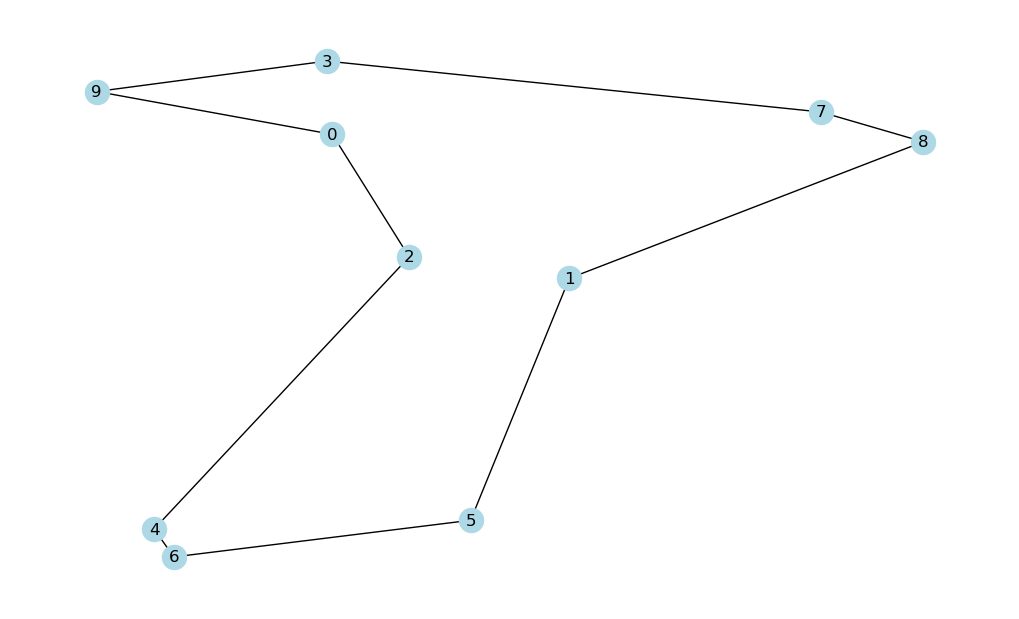

In [81]:
# SCIP - Python Interface

from pyscipopt import Model, quicksum
import numpy as np

# Create problem
model = Model()

# Create variables as a square matrix of binary variables. Note
# the use of p.addVariables to ensure NumPy uses the Xpress operations for handling these vectors.
x = {}
t = {}
for i in range(n):
    for j in range(n):
        x[i,j] = model.addVar(vtype="B", name='x[%i,%i]'%(i,j))
    t[i] = model.addVar(name='t[%i]'%i)

# Degree constraints
for i in CITIES:
    model.addCons(quicksum(x[i,j] for j in CITIES) == 1)
    model.addCons(quicksum(x[j,i] for j in CITIES) == 1)

# Fix diagonals (i.e. city X -> city X) to zero
for i in CITIES:
    model.addCons(x[i,i] == 0)

# Miller, Tucker, Zemlin subtour elimination constraints
for i in range(1,n):
    for j in range(1,n):
        model.addCons(t[j] >= t[i] + 1 - n*(1 - x[i,j]))

# Objective function
model.setObjective(quicksum(dist[i,j]*x[i,j] for i in range(n) for j in range(n)))

model.optimize()

# Plot solution
if model.getNSols() == 0:
    print("No feasible solution found.")
else:
    plot_sol(model)  # print solution and cost

This implementation uses the Miller-Tucker-Zemlin (MTZ) formulation with PySCIPOpt. The key differences from the previous version are:

1. Addition of continuous variables `t[i]` that represent the step at which city i is visited
2. Replacement of the exponential number of subtour elimination constraints with O(n²) MTZ constraints
3. Addition of a symmetry breaking constraint by fixing t[0] = 0
4. Addition of a tour printing feature to show the exact order of cities visited

The MTZ formulation is much more efficient than the previous version as it requires far fewer constraints, though it may provide a weaker LP relaxation.

As you can confirm by the graph and solver logs, this formulation yields the same solution as the previous one, but solves the problem much faster. Let's try to beat that in the next section!

##### Lazy Constraints

Now let's try to speed up the problem creation and solving times even more by using **solver callbacks** to add only those subtour elimination constraints that are really needed during the solving process using the standard formulation.

Callback functions are user–defined routines to be specified to the Optimizer which should be called at various stages during the optimization process, prompting the Optimizer to return to the user's program before continuing with the solution algorithm. They are a useful tool particularly for Mixed Integer Programming (MIP) problems by allowing the user to "interact" with the solver during the solution search process (Branch-and-Bound). 

In our TSP exercise, we will relax (leave out) the subtour elimination constraints, and instead add a callback funtion that is triggered every time an integer (feasible) solution to the relaxed problem is found during the B&B process by using the a Constraint Handler plugin in SCIP, instructing the solver whether to accept (if no subtours) or discard (subtours exist) the solution found, and add the corresponding subtour elimination constraints to the problem in the latter case. Therefore, the user-defined callback function needs to perform two main tasks:
  * checking whether a given solution forms a Hamiltonian tour
  * separating subtour elimination constraints from the current node solution

For more details check https://pyscipopt.readthedocs.io/en/latest/tutorials/lazycons.html


In [82]:
import pyscipopt as scip
import networkx

class SEC(scip.Conshdlr):

    # method for creating a constraint of this constraint handler type
    def createCons(self, name, variables):
        model = self.model
        cons = model.createCons(self, name)

        # data relevant for the constraint; in this case we only need to know which
        # variables cannot form a subtour
        cons.data = {}
        cons.data['vars'] = variables
        return cons


    # find subtours in the graph induced by the edges {i,j} for which x[i][j] is positive
    # at the given solution; when solution is None, the LP solution is used
    def find_subtours(self, cons, solution = None):
        edges = []
        x = cons.data['vars']

        for i in CITIES:
            for j in CITIES:
                if self.model.getSolVal(solution, x[i,j]) > 0.5:
                    edges.append((i, j))

        G = networkx.Graph()
        G.add_edges_from(edges)
        components = list(networkx.connected_components(G))

        if len(components) == 1:
            return []
        else:
            return components

    # checks whether solution is feasible
    def conscheck(self, constraints, solution, check_integrality,
                  check_lp_rows, print_reason, completely, **results):

        # check if there is a violated subtour elimination constraint
        for cons in constraints:
            if self.find_subtours(cons, solution):
                return {"result": scip.SCIP_RESULT.INFEASIBLE}

        # no violated constriant found -> feasible
        return {"result": scip.SCIP_RESULT.FEASIBLE}


    # enforces the LP solution: searches for subtours in the solution and adds
    # adds constraints forbidding all the found subtours
    def consenfolp(self, constraints, n_useful_conss, sol_infeasible):
        consadded = False

        for cons in constraints:
            subtours = self.find_subtours(cons)

            # if there are subtours
            if subtours:
                x = cons.data['vars']

                # add subtour elimination constraint for each subtour
                for S in subtours:
                    print("Constraint added!")
                    self.model.addCons(quicksum(x[i,j] for i in S for j in S if j>i) <= len(S)-1)
                    consadded = True

        if consadded:
            return {"result": scip.SCIP_RESULT.CONSADDED}
        else:
            return {"result": scip.SCIP_RESULT.FEASIBLE}


    # this is rather technical and not relevant for the exercise. to learn more see
    # https://scipopt.org/doc/html/CONS.php#CONS_FUNDAMENTALCALLBACKS
    def conslock(self, constraint, locktype, nlockspos, nlocksneg):
        pass

Now we will solve the problem with the standard formulation (without subtour elimination constraints), but **adding the callback function** and plotting the solution to validate the approach. 

Run the code cell, and verify that the optimal solution values remain the same amongst the three different methods of solving the problem, and compare the running times needed to achieve the optimal solution. You may need to debug/correct the callback function definition in the previous code cell.

Constraint added!presolving:

Constraint added!
Constraint added!
Constraint added!
Constraint added!
Constraint added!
Constraint added!
Constraint added!
Constraint added!
Constraint added!
(round 1, fast)       10 del vars, 10 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 20 clqs
(round 2, exhaustive) 10 del vars, 10 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 20 upgd conss, 0 impls, 20 clqs
   (0.0s) probing: 51/90 (56.7%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation skipped: there exist constraints that cannot be handled by symmetry methods.
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 10 deleted vars, 10 deleted constraints, 0 added constraints, 10 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 20 cliques
presolved problem has 90 variables (90 bin, 

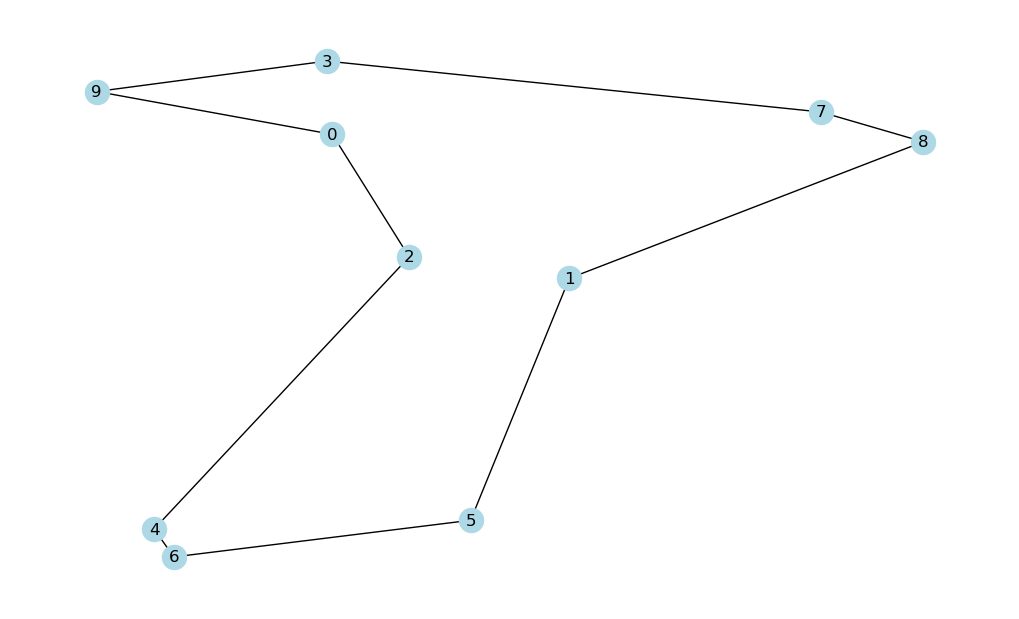

In [83]:
import pyscipopt as scip
import networkx

class SEC(scip.Conshdlr):

    # method for creating a constraint of this constraint handler type
    def createCons(self, name, variables):
        model = self.model
        cons = model.createCons(self, name)

        # data relevant for the constraint; in this case we only need to know which
        # variables cannot form a subtour
        cons.data = {}
        cons.data['vars'] = variables
        return cons


    # find subtours in the graph induced by the edges {i,j} for which x[i][j] is positive
    # at the given solution; when solution is None, the LP solution is used
    def find_subtours(self, cons, solution = None):
        edges = []
        x = cons.data['vars']

        for i in CITIES:
            for j in CITIES:
                if self.model.getSolVal(solution, x[i,j]) > 0.5:
                    edges.append((i, j))

        G = networkx.Graph()
        G.add_edges_from(edges)
        components = list(networkx.connected_components(G))

        if len(components) == 1:
            return []
        else:
            return components

    # checks whether solution is feasible
    def conscheck(self, constraints, solution, check_integrality,
                  check_lp_rows, print_reason, completely, **results):

        # check if there is a violated subtour elimination constraint
        for cons in constraints:
            if self.find_subtours(cons, solution):
                return {"result": scip.SCIP_RESULT.INFEASIBLE}

        # no violated constriant found -> feasible
        return {"result": scip.SCIP_RESULT.FEASIBLE}


    # enforces the LP solution: searches for subtours in the solution and adds
    # adds constraints forbidding all the found subtours
    def consenfolp(self, constraints, n_useful_conss, sol_infeasible):
        consadded = False

        for cons in constraints:
            subtours = self.find_subtours(cons)

            # if there are subtours
            if subtours:
                x = cons.data['vars']

                # add subtour elimination constraint for each subtour
                for S in subtours:
                    print("Constraint added!")
                    self.model.addCons(scip.quicksum(x[i,j] for i in S for j in S) <= len(S)-1)
                    consadded = True

        if consadded:
            return {"result": scip.SCIP_RESULT.CONSADDED}
        else:
            return {"result": scip.SCIP_RESULT.FEASIBLE}


    # this is rather technical and not relevant for the exercise. to learn more see
    # https://scipopt.org/doc/html/CONS.php#CONS_FUNDAMENTALCALLBACKS
    def conslock(self, constraint, locktype, nlockspos, nlocksneg):
        pass


model = scip.Model()

x = {}
for i in CITIES:
    for j in CITIES:
        x[i, j] = model.addVar(vtype="B", name="x_{i}_{j}", obj=dist[i][j])

# Degree constraints
for i in CITIES:
    model.addCons(scip.quicksum(x[i,j] for j in range(n)) == 1)
    model.addCons(scip.quicksum(x[j,i] for j in range(n)) == 1)
    model.addCons(x[i,i] == 0)
    
# create the constraint handler
conshdlr = SEC()

# Add the constraint handler to SCIP. We set check priority < 0 so that only integer feasible solutions
# are passed to the conscheck callback
model.includeConshdlr(conshdlr, "TSP", "TSP subtour eliminator", chckpriority = -10, enfopriority = -10)

# create a subtour elimination constraint
cons = conshdlr.createCons("no_subtour_cons", x)

# add constraint to SCIP
model.addPyCons(cons)

model.optimize()

plot_sol(model)

As we can observe, the problem has been solved even faster than using the MTZ formulation, yielding the same solution and objective value in considerably less time, making the problem even more scalable. 